In [1]:
using PyPlot

In [2]:
#-------------Finite difference Laplace Solver-----------------#
#Solving the laplace equation using the standard 5-point difference scheme
#------------1.The Mesh-----------------------------------------#
function lshape(N)
    # make sure N is even
    N = round(Int, N/2) * 2
    # create a zero-array (the `Int` tells Julia to make it integers)
    L = zeros(Int, N+2, N+2)
    # fill in the "domain" with ones
    # note the ÷ : this is integer division 
    #    (Julia does not like indexing with non-integers)
    L[2:N ÷ 2+1,2:N+1] = 1
    L[2:N+1,N ÷ 2+2:N+1] = 1
    # return the completed array
    return L
end

# generate a mesh for demonstration
L = lshape(9)
println(L)

[0 0 0 0 0 0 0 0 0 0; 0 1 1 1 1 1 1 1 1 0; 0 1 1 1 1 1 1 1 1 0; 0 1 1 1 1 1 1 1 1 0; 0 1 1 1 1 1 1 1 1 0; 0 0 0 0 0 1 1 1 1 0; 0 0 0 0 0 1 1 1 1 0; 0 0 0 0 0 1 1 1 1 0; 0 0 0 0 0 1 1 1 1 0; 0 0 0 0 0 0 0 0 0 0]


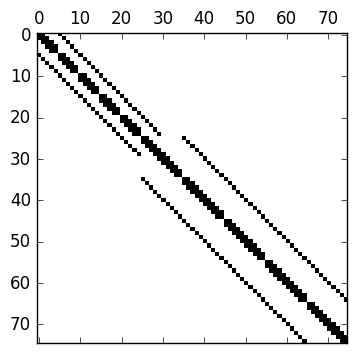

In [3]:
#----------------------2. The laplace operator----------------------------#
function fdlaplacian(G)
    # read info about G
    M, N = size(G)
    nonz = find(G)
    # define function to create a 1D laplacian and a sparse identity
    fdl1(m) = spdiagm((ones(m-1),-2*ones(m),ones(m-1)), [-1,0,1])
    # laplace operator on the full grid
    A = kron(speye(M), fdl1(N)) + kron(fdl1(M), speye(N))
    # return the restriction to the coloured grid points
    return A[nonz, nonz]
end

# do a spy plot of the laplacian matrix
# the `figsize` property adjusts the size of the figure
figure(figsize=[4,4])
spy(fdlaplacian(lshape(10)))

# the `;` ensures that we don't get a weird output 
# at the end of the cell that we don't want
;

In [4]:
#----------------------------Solving the PDE-----------------------------#
# assemble the right-hand side
N = 60
L = lshape(N)
A = - fdlaplacian(L)
b = ones(size(A,1)) / N^2
# solve the linear system > this uses UMFPACK (same as Matlab)
# the ; supresses output
u = A \ b;

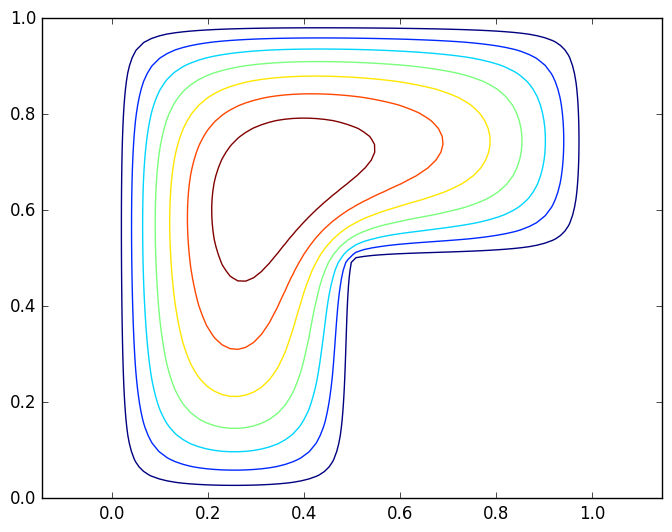

/Users/work/anaconda/lib/python2.7/site-packages/numpy/ma/core.py:6434: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/Users/work/anaconda/lib/python2.7/site-packages/numpy/ma/core.py:6434: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


In [5]:
#------------------------------3. Basic plotting--------------------#
# create the grid on which we are solving the FD equantion
#             (why does Julia not implement meshgrid?!?!)
X = (linspace(0, 1, N+2) * ones(1, N+2)); Y = X'
# write solution into plottable format
U = zeros(size(L))
U[find(L)] = u
# call the correct PyPlot routine
contour(X, Y, U)
axis("equal");

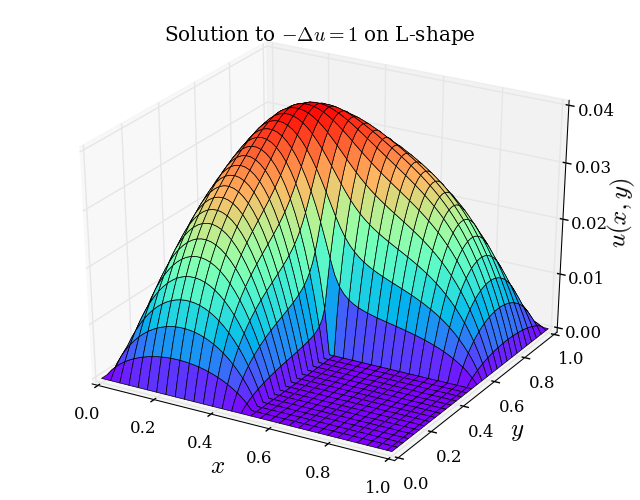

In [6]:
# the next line makes the standard font serif, to match
# the standard Latex fonts in publications
PyPlot.rc("font", family="serif")
# set the following line to true if you want the plot in a separate interactive window
pygui(false)
# plot the wireframe mesh
surf(X, Y, U, rstride=2, cstride=2, 
      cmap=ColorMap("rainbow"), linewidth=0.5)
# some latex labels
title(L"Solution to $-\Delta u = 1$ on L-shape")
xlabel(L"$x$", fontsize=18); 
ylabel(L"$y$", fontsize=18); 
zlabel(L"$u(x,y)$", fontsize=18)
# some axis formatting
xticks([0,.2,.4,.6,.8,1])
yticks([0,.2,.4,.6,.8,1])
zticks([0,.01,.02,.03,.04])
# setting svg -> true gives better quality plot 
# (also makes the notebook slower, so only use for final version.)
# then uncomment the `savefig` line to save the resulting figure
PyPlot.svg(false);
# savefig("plot.svg");

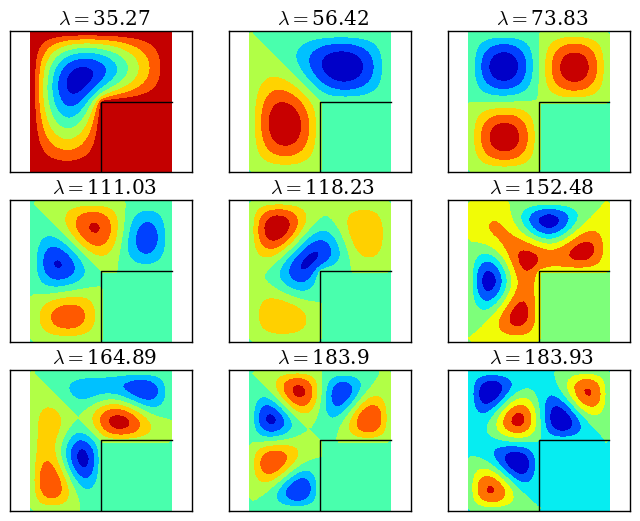

In [7]:
#-----------------------4.Eigenvalue solver----------------------#
##### assemble the laplacian
N = 40
L = lshape(N)
X = (linspace(0, 1, N+2) * ones(1, N+2)); Y = X'
A = - fdlaplacian(L)*N^2

# get the first 9 eigenvalues
# Note that `:SM` is a Symbol (see Julia docs)
lam, v, = eigs(A; nev=9, which=:SM, tol=0.0, maxiter=1000, ritzvec=true)

# plot the results
for i = 1:9
    subplot(3,3,i)
    V = zeros(size(X))
    V[find(L)] = v[:, i]
    contourf(X, Y, V)
    plot([.5,.5,1], [0,.5,.5], "k-")
    title(string(L" $\lambda = $", round(lam[i], 2)))
    xticks([]); yticks([]); axis("equal");
end